In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

In [3]:
from keras.applications import ResNet50V2
model = ResNet50V2(weights='imagenet', include_top=False)

img_width = 180
img_height = 180

layer_name = "conv3_block4_out"
layer = model.get_layer(name=layer_name)
feature_extractor = keras.Model(inputs=model.inputs, outputs=layer.output)

model.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, None, None, 3)        0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, None, None, 64)       9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, None, None, 64)       0         ['conv1_conv[0][0]']          
                                                                                         

Build a feature extarction model

In [9]:
from keras.applications.vgg16 import VGG16, preprocess_input
model = VGG16(weights='imagenet', include_top=True)

img_width = 224
img_height = 224

layer_name = "predictions"
layer = model.get_layer(name=layer_name)
feature_extractor = keras.Model(inputs=model.inputs, outputs=layer.output)

model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

Set up a Gradient Ascent process

In [13]:
from keras.preprocessing.image import load_img, img_to_array

def compute_loss(input_image, filter_index):
    activation = feature_extractor(input_image)
    print(activation.shape)
    # We avoid border artifacts by only involving non-border pixels in the loss.
    #filter_activation = activation[:, 2:-2, 2:-2, filter_index]
    filter_activation = activation[:, filter_index]

    return tf.reduce_mean(filter_activation)

def gradient_ascent_step(img, filter_index, learning_rate):
    with tf.GradientTape() as tape:
        tape.watch(img)
        loss = compute_loss(img, filter_index)
        print(loss)

    grads = tape.gradient(loss, img)
    grads = tf.math.l2_normalize(grads)
    img += grads*learning_rate
    return loss, img

def initialize_image_resnet():
    # We start from a gray image with some random noise
    img = tf.random.uniform((1, img_width, img_height, 3))
    
    # ResNet50V2 expects inputs in the range [-1, +1].
    # Here we scale our random inputs to [-0.125, +0.125]
    return (img - 0.5) * 0.25

def initialize_image_vgg():
    # We start from a gray image with some random noise
    #img = tf.random.uniform((1, img_width, img_height, 3))
    img = load_img("clear_blue_sky.jpg",target_size=(224,224))
    img = preprocess_input(img)
    img = tf.convert_to_tensor(img)
    return img


def visualize_filter(filter_index):
    # We run gradient ascent for 20 steps
    iterations = 30
    learning_rate = 10.0
    #img = initialize_image_resnet()
    img = initialize_image_vgg()
    for iteration in range(iterations):
        loss, img = gradient_ascent_step(img, filter_index, learning_rate)

    # Decode the resulting input image
    img = deprocess_image(img[0].numpy())
    return loss, img


def deprocess_image(img):
    # Normalize array: center on 0., ensure variance is 0.15
    img -= img.mean()
    img /= img.std() + 1e-5
    img *= 0.15

    # Center crop
    img = img[25:-25, 25:-25, :]

    # Clip to [0, 1]
    img += 0.5
    img = np.clip(img, 0, 1)

    # Convert to RGB array
    img *= 255
    img = np.clip(img, 0, 255).astype("uint8")
    return img

In [12]:
from IPython.display import Image, display

loss, img = visualize_filter(291)
keras.utils.save_img("1.png", img)

ValueError: Passed in object [[[ 73.061      -8.778999  -85.68     ]
  [ 72.061      -6.7789993 -84.68     ]
  [ 73.061      -5.7789993 -83.68     ]
  ...
  [ 89.061      11.221001  -69.68     ]
  [ 89.061      11.221001  -69.68     ]
  [ 89.061      11.221001  -69.68     ]]

 [[ 73.061      -8.778999  -85.68     ]
  [ 72.061      -6.7789993 -84.68     ]
  [ 73.061      -5.7789993 -83.68     ]
  ...
  [ 89.061      11.221001  -69.68     ]
  [ 89.061      11.221001  -69.68     ]
  [ 89.061      11.221001  -69.68     ]]

 [[ 75.061      -6.7789993 -83.68     ]
  [ 73.061      -5.7789993 -83.68     ]
  [ 74.061      -3.7789993 -84.68     ]
  ...
  [ 89.061      11.221001  -69.68     ]
  [ 89.061      11.221001  -69.68     ]
  [ 89.061      11.221001  -69.68     ]]

 ...

 [[121.061      71.221      -3.6800003]
  [121.061      71.221      -3.6800003]
  [122.061      70.221      -5.6800003]
  ...
  [121.061      62.221     -22.68     ]
  [121.061      62.221     -22.68     ]
  [120.061      61.221     -23.68     ]]

 [[123.061      75.221       0.3199997]
  [125.061      75.221       0.3199997]
  [126.061      74.221      -0.6800003]
  ...
  [119.061      63.221     -22.68     ]
  [119.061      63.221     -22.68     ]
  [118.061      62.221     -23.68     ]]

 [[123.061      75.221       0.3199997]
  [125.061      75.221       0.3199997]
  [126.061      74.221      -0.6800003]
  ...
  [119.061      63.221     -22.68     ]
  [119.061      63.221     -22.68     ]
  [118.061      62.221     -23.68     ]]] of type 'ndarray', not tf.Tensor or tf.Variable or ExtensionType.

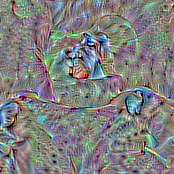

In [8]:
display(Image("1.png"))